In [1]:
import torch
import torchvision.transforms as transforms
from torchvision import models

from PIL import Image

class GenerateEmbeddings:
    def __init__(self):
        self.model = models.resnet50(pretrained=True)
        self.model = torch.nn.Sequential(*list(self.model.children())[:-1])  # Remover a última camada de classificação
        self.model.eval()

        self.transform = transforms.Compose([
            transforms.Resize(224),
            transforms.Grayscale(num_output_channels=3),
            transforms.ToTensor(),

            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

    def __call__(self, image):
        image = image.unsqueeze(0) 
        with torch.no_grad():
            embedding = self.model(image)
            embedding = embedding.view(embedding.size(0), -1)
        embedding = embedding.squeeze().numpy()
        
        return embedding
    

In [ ]:
from pymilvus import MilvusClient

client = MilvusClient(uri="http://seu_host_milvus:19530")
collection_name="image_embeddings"

if client.has_collection(collection_name="image_embeddings"):
    client.drop_collection(collection_name="image_embeddings")
client.create_collection(
    collection_name=collection_name,
    vector_field_name="vector",
    dimension=2048,
    auto_id=True,
    enable_dynamic_field=True,
    metric_type="COSINE",
)

In [5]:
import os
from torchvision import datasets
import matplotlib.pyplot as plt

generateEmbedding = GenerateEmbeddings()

transform = generateEmbedding.transform

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

for idx in range(2000):
    image, label = train_dataset[idx]

    embedding = generateEmbedding(image)
    
    client.insert(
                    "image_embeddings",
                    {"vector": embedding, "image_index": idx},
                )

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.82MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 196kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 1.84MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 20.8MB/s]


In [6]:
import matplotlib.pyplot as plt
import numpy as np

def show_image(image, label, distance=None):
    if hasattr(image, 'numpy'):
        image = image.numpy()

    if image.shape[0] == 3:
        image = np.transpose(image, (1, 2, 0))  # Move os canais para o último eixo

    plt.imshow(image)
    plt.title(f'Label: {label} - Dist: {distance}') if distance else plt.title(f'Label: {label}')
    plt.show()

def search_image(milvus_client, query_data, train_dataset, top_k=3):
    image, label = query_data

    generateEmbedding = GenerateEmbeddings()
    queryEmbedding = generateEmbedding(image)
    print("Query Image: ")
    show_image(image, label)
    milvus_client.load_collection(collection_name=collection_name) # Carrega os dados do OBJS para a memória
    results = milvus_client.search(
        "image_embeddings",
        data=[np.array(queryEmbedding)],
        output_fields=["label", "image_index"],
        limit=top_k,
        search_params={"metric_type": "COSINE"},
    )
    
    print("Results: ")
    for result in results:
        for hit in result:
            distance = hit.get("distance")
            image = train_dataset[hit.get("entity").get("image_index")][0]
            lb = hit.get("entity").get("label")
            show_image(image, lb, distance)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].


Query Image: 


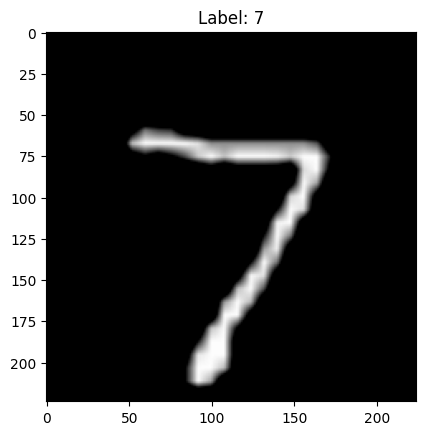

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].


Results: 


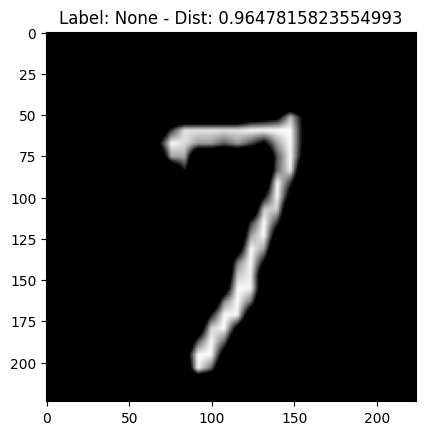

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


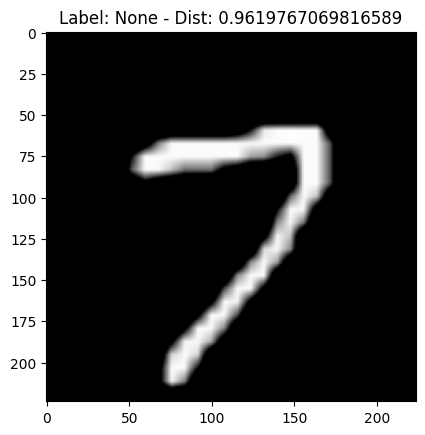

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].


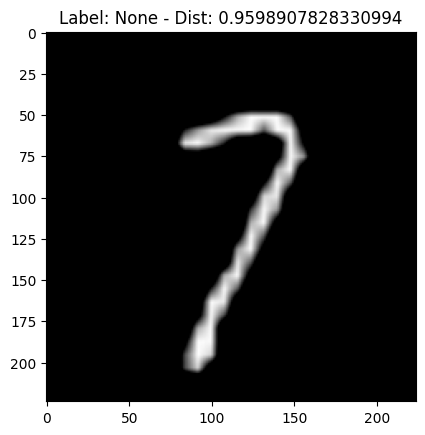

In [7]:
search_image(client, test_dataset[0], train_dataset=train_dataset)